In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(
    '/content/drive/MyDrive/metadata.csv')

print(f"Loaded {len(df)} papers.")

/tmp/ipython-input-1557319198.py:1: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


Loaded 1056660 papers.


In [ ]:
df_sample = df.sample(n=10000, random_state=42)
print(df_sample.head())

        cord_uid                                       sha  source_x  \
17948   ak20jg32  42a61efa32fae8fb14d1c8c1a8bc528c59e1583a       PMC   
915932  d27cnei3                                       NaN  PMC; WHO   
456857  7fo988o7                                       NaN       WHO   
176672  vcz81w3o                                       NaN   Medline   
40038   3ewr26np                                       NaN       PMC   

                                                    title  \
17948   Development and Internal Validation of a Novel...   
915932  mRNA-1273: Acute disseminated encephalomyeliti...   
456857  The Joint Commission should reconsider its pos...   
176672  Flattening the Curve of Prostate Cancer Progre...   
40038        Vincristine: Various toxicities: case report   

                                 doi       pmcid   pubmed_id license  \
17948      10.3389/fpsyt.2021.593710  PMC8172985    34093252   cc-by   
915932    10.1007/s40278-021-06200-0  PMC8617002        

In [ ]:
print(f"\n DataFrame dimensions: {df_sample.shape[0]:,} rows, {df_sample.shape[1]} columns")
print("\n First 3 rows:")
print(df_sample.head(3))

print("\n Column data types:")
print(df_sample.dtypes)

print("\n Missing values per column:")
print(df_sample.isnull().sum().sort_values(ascending=False))

# Basic stats
print("\n Note: No numerical columns → skipping numerical statistics.")


 DataFrame dimensions: 10,000 rows, 19 columns

 First 3 rows:
        cord_uid                                       sha  source_x  \
17948   ak20jg32  42a61efa32fae8fb14d1c8c1a8bc528c59e1583a       PMC   
915932  d27cnei3                                       NaN  PMC; WHO   
456857  7fo988o7                                       NaN       WHO   

                                                    title  \
17948   Development and Internal Validation of a Novel...   
915932  mRNA-1273: Acute disseminated encephalomyeliti...   
456857  The Joint Commission should reconsider its pos...   

                               doi       pmcid pubmed_id license  \
17948    10.3389/fpsyt.2021.593710  PMC8172985  34093252   cc-by   
915932  10.1007/s40278-021-06200-0  PMC8617002       NaN   no-cc   
456857                         NaN         NaN       NaN     unk   

                                                 abstract publish_time  \
17948   Objective: The aim of our study was to identif.

In [ ]:
# DATA CLEANING AND PREPARATION

print("Starting shape:", df.shape)

# IDENTIFY COLUMNS WITH HIGH MISSING VALUES
missing = df_sample.isnull().sum()
missing_pct = (missing / len(df_sample)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)

print("\n Columns with highest missing %:")
print(missing_summary.head(10))

Starting shape: (1056660, 19)

 Columns with highest missing %:
                  Missing Count  Missing %
mag_id                    10000     100.00
arxiv_id                   9858      98.58
pmc_json_files             7001      70.01
sha                        6457      64.57
pdf_json_files             6457      64.57
pmcid                      6309      63.09
who_covidence_id           5508      55.08
pubmed_id                  5305      53.05
doi                        3703      37.03
url                        3429      34.29


In [ ]:
# SELECT ONLY COLUMNS NEEDED FOR ANALYSIS
columns_to_keep = [
    'cord_uid',      # unique ID
    'title',         # for display
    'abstract',
    'publish_time',  # critical for time analysis
    'journal',       # for top journals
    'source_x'       # for source distribution
]

df_clean = df_sample[columns_to_keep].copy()

#  DROP ROWS WITH MISSING title OR publish_time (very few)
print(f"Before dropping missing title/publish_time: {df_clean.shape[0]:,}")
df_clean = df_clean.dropna(subset=['title', 'publish_time'])
print(f"After dropping: {df_clean.shape[0]:,}")

# FILL MISSING journal WITH 'Unknown'
df_clean['journal'] = df_clean['journal'].fillna('Unknown')

# HANDLE publish_time → CONVERT TO YEAR
def extract_year(date_str):
    """
    Extract 4-digit year from date strings.
    Handles: '2020', '2020-03', '2020-03-15', '2020 Mar', etc.
    """
    if pd.isna(date_str):
        return None
    # Convert to string and take first 4 characters
    date_str = str(date_str).strip()
    if len(date_str) >= 4:
        try:
            year = int(date_str[:4])
            # Only accept reasonable years
            if 1900 <= year <= 2024:
                return year
        except ValueError:
            pass
    return None

# Apply function
df_clean['year'] = df_clean['publish_time'].apply(extract_year)

# Drop rows where year extraction failed
print(f"Before dropping invalid years: {df_clean.shape[0]:,}")
df_clean = df_clean.dropna(subset=['year'])
df_clean['year'] = df_clean['year'].astype(int)  # convert to int
print(f"After dropping invalid years: {df_clean.shape[0]:,}")

# 6. CREATE NEW COLUMN: abstract word count
df_clean['abstract_word_count'] = (
    df_clean['abstract']
    .fillna('')  # replace NaN with empty string
    .str.split()  # split into words
    .str.len()    # count words
)

# FINAL CLEANED DATASET
final_columns = [
    'cord_uid', 'title', 'abstract', 'year',
    'journal', 'source_x', 'abstract_word_count'
]
df_final = df_clean[final_columns].reset_index(drop=True)

print("\n CLEANING COMPLETE!")
print(f"Final dataset shape: {df_final.shape[0]:,} rows, {df_final.shape[1]} columns")
print("\nSample of cleaned data:")
print(df_final.head(3))

Before dropping missing title/publish_time: 10,000
After dropping: 9,982
Before dropping invalid years: 9,982
After dropping invalid years: 9,981

 CLEANING COMPLETE!
Final dataset shape: 9,981 rows, 7 columns

Sample of cleaned data:
   cord_uid                                              title  \
0  ak20jg32  Development and Internal Validation of a Novel...   
1  d27cnei3  mRNA-1273: Acute disseminated encephalomyeliti...   
2  7fo988o7  The Joint Commission should reconsider its pos...   

                                            abstract  year  \
0  Objective: The aim of our study was to identif...  2021   
1                                                NaN  2021   
2                                                NaN  2020   

                journal  source_x  abstract_word_count  
0      Front Psychiatry       PMC                  198  
1      Reactions Weekly  PMC; WHO                    0  
2  Gen. hosp. psychiatr       WHO                    0  


In [ ]:
# Check for any remaining missing in critical columns
print("\n Missing values in final dataset:")
print(df_final.isnull().sum())

# Check year range
print(f"\n Year range: {df_final['year'].min()} – {df_final['year'].max()}")

# Check journal distribution (top 5)
print("\n Top 5 journals:")
print(df_final['journal'].value_counts().head())


 Missing values in final dataset:
cord_uid                  0
title                     0
abstract               2217
year                      0
journal                   0
source_x                  0
abstract_word_count       0
dtype: int64

 Year range: 1968 – 2022

 Top 5 journals:
journal
Unknown                            867
bioRxiv                             98
PLoS One                            88
Int J Environ Res Public Health     76
Sci Rep                             54
Name: count, dtype: int64


In [ ]:
df_final.to_csv('/content/drive/MyDrive/cord-19-sample.csv', index=False)
print ("Sample dataset saved to 'cord-19-sample.csv'")

Sample dataset saved to 'cord-19-sample.csv'


In [ ]:
# DATA ANALYSIS AND VISUALIZATION ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')

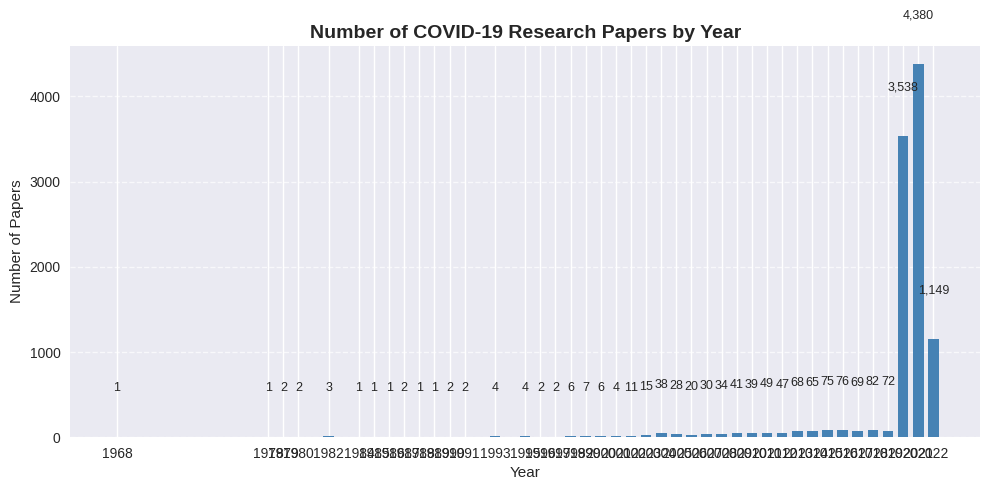

In [ ]:
# 1. Count papers by publication year

year_counts = df_final['year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
bars = plt.bar(year_counts.index, year_counts.values, color='steelblue', width=0.7)
plt.title('Number of COVID-19 Research Papers by Year', fontsize=14, weight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(year_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
             f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

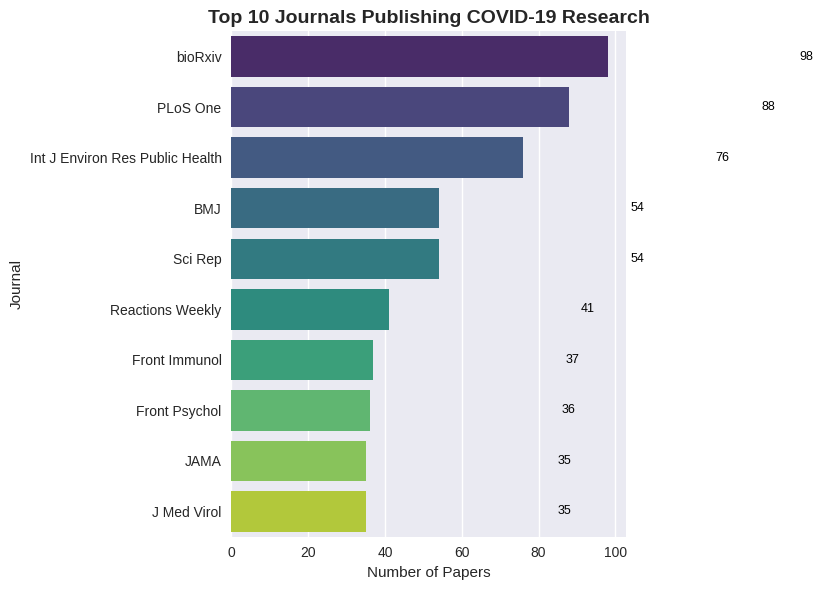

In [ ]:
# 2. Identify top journals publishing COVID-19 research

# Exclude 'Unknown' to focus on real journals
journals_real = df_final[df_final['journal'] != 'Unknown']['journal']
top_journals = journals_real.value_counts().head(10)

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=top_journals.values, y=top_journals.index, palette='viridis')
plt.title('Top 10 Journals Publishing COVID-19 Research', fontsize=14, weight='bold')
plt.xlabel('Number of Papers')
plt.ylabel('Journal')

# Add value labels
for i, v in enumerate(top_journals.values):
    plt.text(v + 50, i, f"{v:,}", color='black', va='center', fontsize=9)

plt.tight_layout()
plt.show()

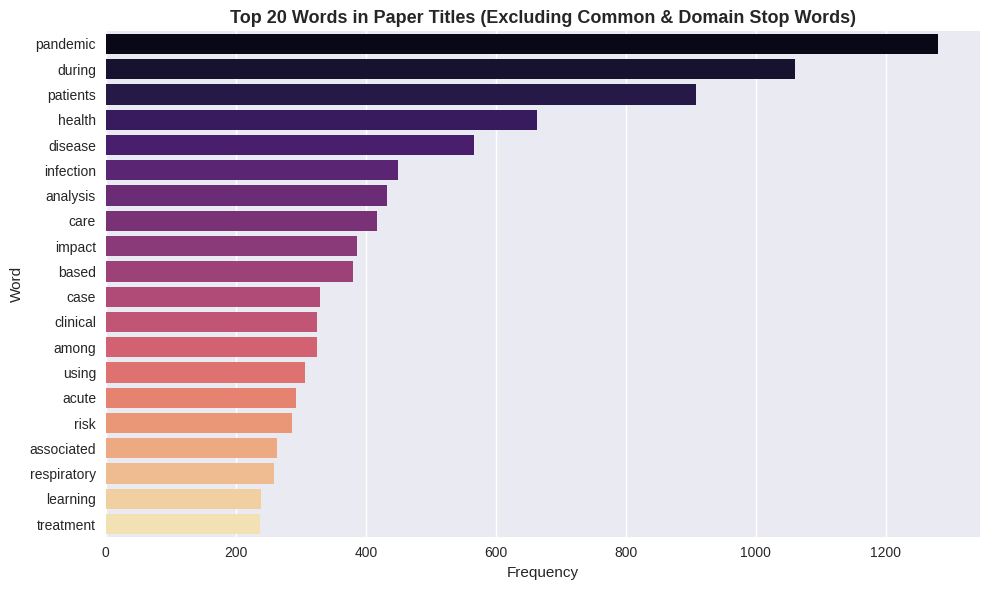

In [ ]:
#3. Find most frequent words in titles (simple word frequency)

# Combine all titles into one string
all_titles = ' '.join(df_final['title'].astype(str).str.lower())

# Clean: keep only letters and spaces
all_titles_clean = re.sub(r'[^a-z\s]', ' ', all_titles)

# Split into words
words = all_titles_clean.split()

# Define stop words (common words to ignore)
stop_words = {
    'the', 'and', 'of', 'a', 'in', 'to', 'for', 'on', 'with', 'by', 'an', 'as', 'is', 'are',
    'was', 'were', 'be', 'or', 'that', 'this', 'at', 'from', 'it', 'which', 'but', 'not',
    'have', 'has', 'had', 'been', 'will', 'would', 'could', 'should', 'may', 'might', 'can',
    'co', 'http', 'doi', 'org', 'preprint', 'review', 'article', 'paper', 'study', 'research',
    'covid', 'covid19', 'sars', 'cov', 'coronavirus', 'virus', 'viral'  # domain-specific
}

# Filter words: length > 2 and not in stop words
filtered_words = [word for word in words if len(word) > 2 and word not in stop_words]

# Get top 20
top_words = Counter(filtered_words).most_common(20)

# Plot
words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 6))
sns.barplot(data=words_df, x='Frequency', y='Word', palette='magma')
plt.title('Top 20 Words in Paper Titles (Excluding Common & Domain Stop Words)', fontsize=13, weight='bold')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

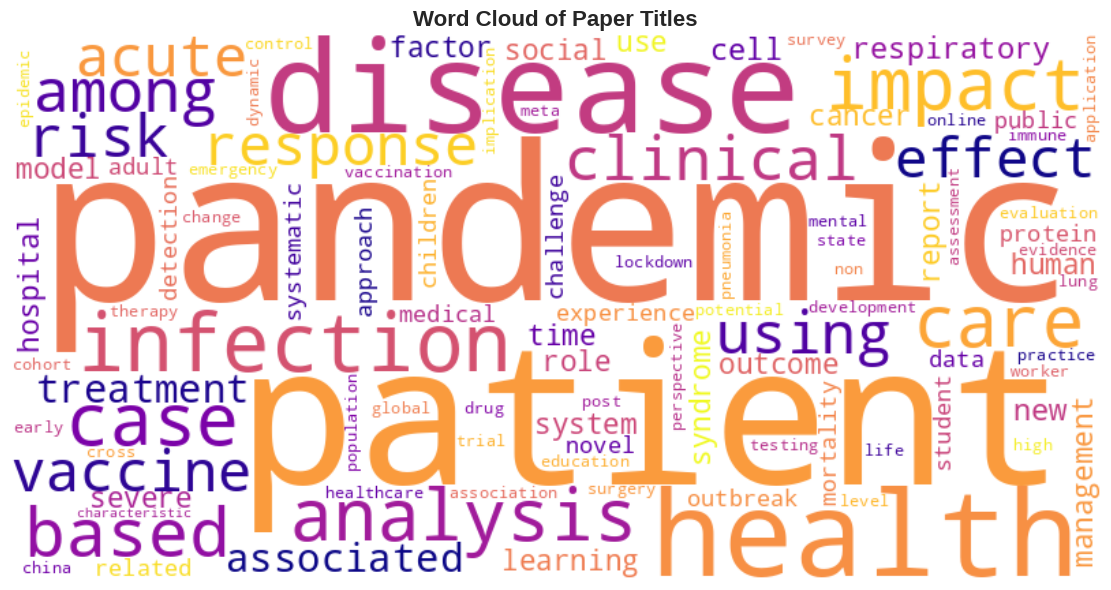

In [ ]:
# 4. Generate a word cloud of paper titles

# Create word cloud from filtered words
wordcloud_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    colormap='plasma',
    collocations=False  # avoids double-counting "covid 19" as "covid" and "19"
).generate(wordcloud_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Paper Titles', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

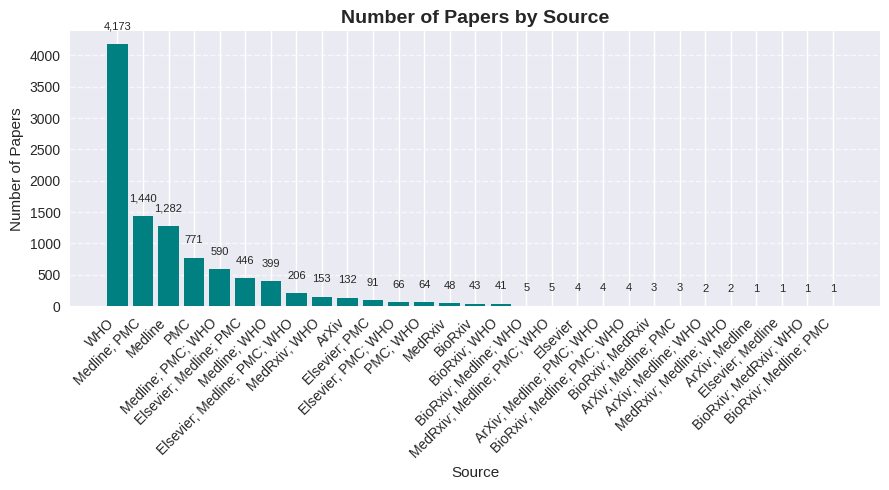


 Top sources:
source_x
WHO                  4173
Medline; PMC         1440
Medline              1282
PMC                   771
Medline; PMC; WHO     590
Name: count, dtype: int64


In [ ]:
# 4. Plot distribution of paper counts by source (source_x)

source_counts = df_final['source_x'].value_counts()

plt.figure(figsize=(9, 5))
bars = plt.bar(source_counts.index, source_counts.values, color='teal')
plt.title('Number of Papers by Source', fontsize=14, weight='bold')
plt.xlabel('Source')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
             f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print top sources
print("\n Top sources:")
print(source_counts.head())